**Table of Contents** <br>
* [1. Import Libraries and Dataset](#importld)
* [2. Perspectives](#perspectives)

<hr>
<a class="anchor" id="importld">
    
# 1. Import Libraries and Dataset
    
</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

sns.set()

In [2]:
df = pd.read_csv('datasets/data_clean.csv')

<hr>
<a class="anchor" id="importdataset">
    
# 2. Perspectives
    
</a>

In [3]:
df.head()

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,Total_Orders,Total_Spent,Spent_Per_Order,Items_Per_Order,...,CUI_Chinese,CUI_Desserts,CUI_Healthy,CUI_Indian,CUI_Italian,CUI_Japanese,CUI_Noodle_Dishes,CUI_OTHER,CUI_Street_Food/Snacks,CUI_Thai
0,0.107143,0.142857,0.296296,0.166667,0.0,0.011111,0.125,0.306394,0.578417,1.0,...,0.0,0.0,0.0,28.88,0.0,0.0,0.0,0.0,0.0,0.0
1,0.071429,0.142857,0.074074,0.333333,0.0,0.011111,0.125,0.202472,0.379445,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,0.821429,0.000000,0.074074,0.333333,0.0,0.011111,0.125,0.094895,0.173895,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,0.428571,0.142857,0.148148,0.166667,0.0,0.022222,0.125,0.335196,0.633505,0.4,...,0.0,0.0,0.0,17.86,0.0,0.0,0.0,0.0,0.0,0.0
4,0.178571,0.142857,0.296296,0.000000,0.0,0.022222,0.125,0.591832,1.000000,1.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['customer_age', 'vendor_count', 'product_count', 'is_chain',
       'first_order', 'last_order', 'Total_Orders', 'Total_Spent',
       'Spent_Per_Order', 'Items_Per_Order', 'Frequency', 'Loyalty',
       'Time_with_us', 'CUI_diversity', 'Night', 'Day', 'Dinner', 'Weekdays',
       'Weekends', 'Asian', 'Western', 'Other', 'customer_region',
       'last_promo', 'payment_method', 'Age_Group', 'DOW_0', 'DOW_1', 'DOW_2',
       'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3',
       'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10', 'HR_11',
       'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19',
       'HR_20', 'HR_21', 'HR_22', 'HR_23', 'CUI_American', 'CUI_Asian',
       'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken_Dishes', 'CUI_Chinese',
       'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian',
       'CUI_Japanese', 'CUI_Noodle_Dishes', 'CUI_OTHER',
       'CUI_Street_Food/Snacks', 'CUI_Thai'],
      dtype='object')

In [5]:
# Split variables into perspectives
behavior_features = ['Total_Orders',
                     'Spent_Per_Order',  
                     'Time_with_us']

time_features = ['Night', 'Day', 'Dinner']

preferences_features = ['Asian', 'Western', 'Other']

df_beh = df[behavior_features]
df_time = df[time_features]
df_pref = df[preferences_features]

# drop categorical and object columns to get means of each cluster
non_metric = df[['customer_region', 'last_promo', 'payment_method', 'Age_Group']]
df = df.drop(non_metric, axis=1)

<hr>
<a class="anchor" id="kmclustering">
    
# 3. K-means Clustering
    
</a>

In [6]:
def get_ss_variables(df):
    """
    Calculate the sum of squares (SS) for each variable in the DataFrame.
    
    Parameters:
        df (DataFrame): Input DataFrame with numeric columns.
        
    Returns:
        Series: Sum of squares for each column.
    """
    ss_vars = df.var(ddof=0) * (len(df) - 1)  # ddof=0 for population variance
    return ss_vars

def r2_variables(df, labels):
    """
    Calculate the R² for each variable in the DataFrame.
    
    Parameters:
        df (DataFrame): Input DataFrame with numeric columns.
        labels (str or Series): Column or array-like representing labels/groups.
        
    Returns:
        Series: R² value for each variable.
    """
    # Calculate total sum of squares (SST)
    sst_vars = get_ss_variables(df)
    
    # Calculate within-group sum of squares (SSW)
    ssw_vars = df.groupby(labels).apply(get_ss_variables).sum()
    
    # Calculate R² for each variable
    r2_values = 1 - (ssw_vars / sst_vars)
    return r2_values

<hr>
<a class="anchor" id="kmbeh">
    
## 3.1 Behavior Features

#### Defining the number of clusters

In [7]:
range_clusters = range(1, 11)

In [8]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=50, random_state=202)
    kmclust.fit(df_beh)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

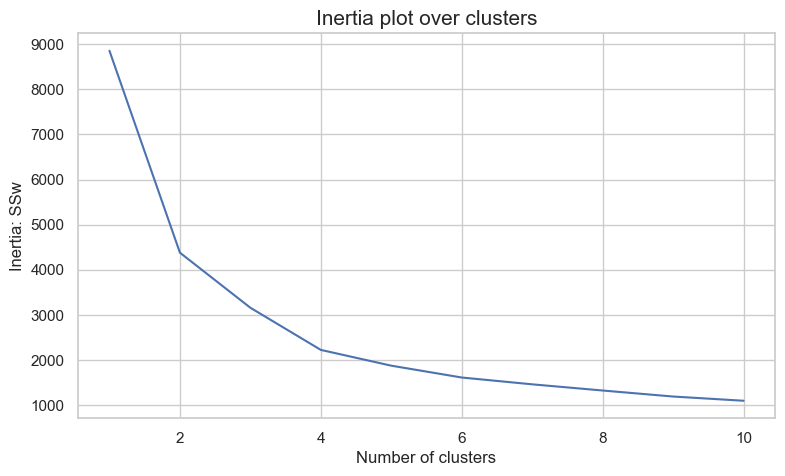

In [9]:
# The inertia plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.3971497833282914
For n_clusters = 3, the average silhouette_score is : 0.3955003600165698
For n_clusters = 4, the average silhouette_score is : 0.399481681767867
For n_clusters = 5, the average silhouette_score is : 0.41438004679027124
For n_clusters = 6, the average silhouette_score is : 0.40988572498804327
For n_clusters = 7, the average silhouette_score is : 0.36288495353766803
For n_clusters = 8, the average silhouette_score is : 0.3709446478401913
For n_clusters = 9, the average silhouette_score is : 0.38182236051158325
For n_clusters = 10, the average silhouette_score is : 0.3764295766935262


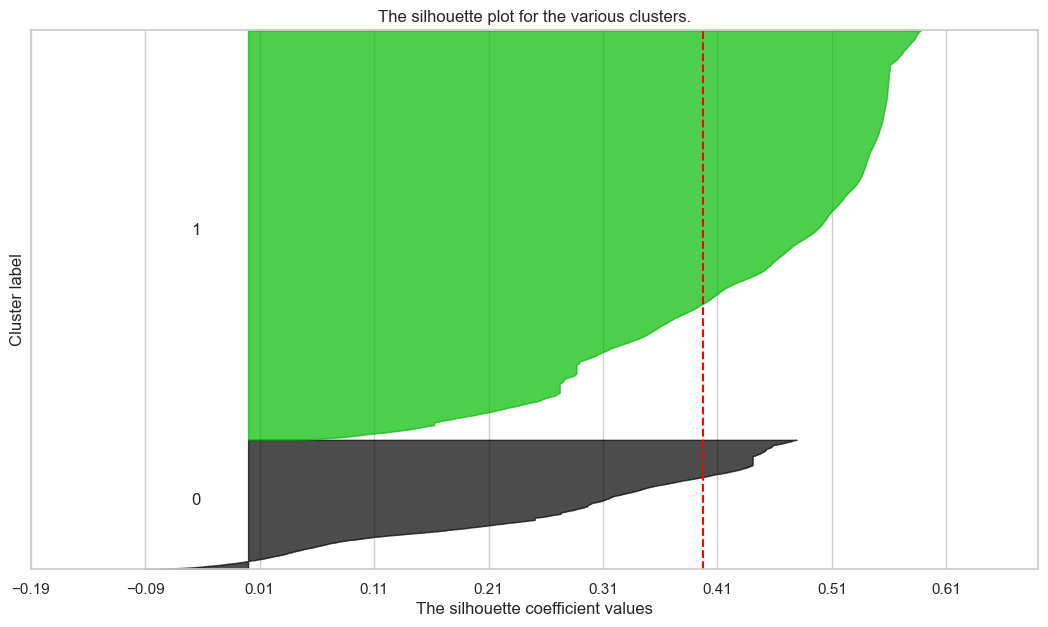

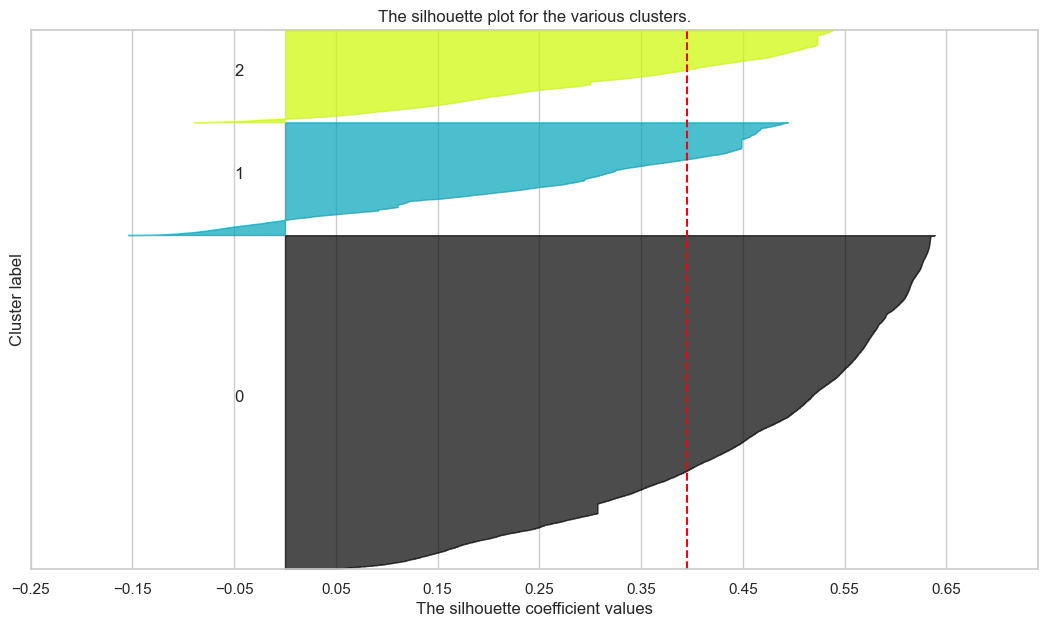

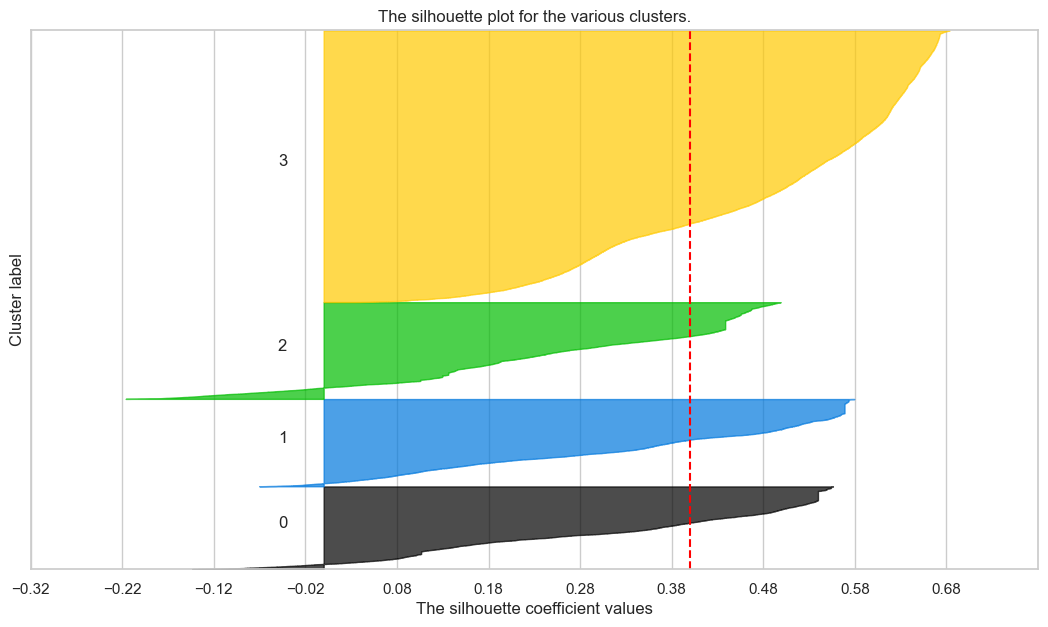

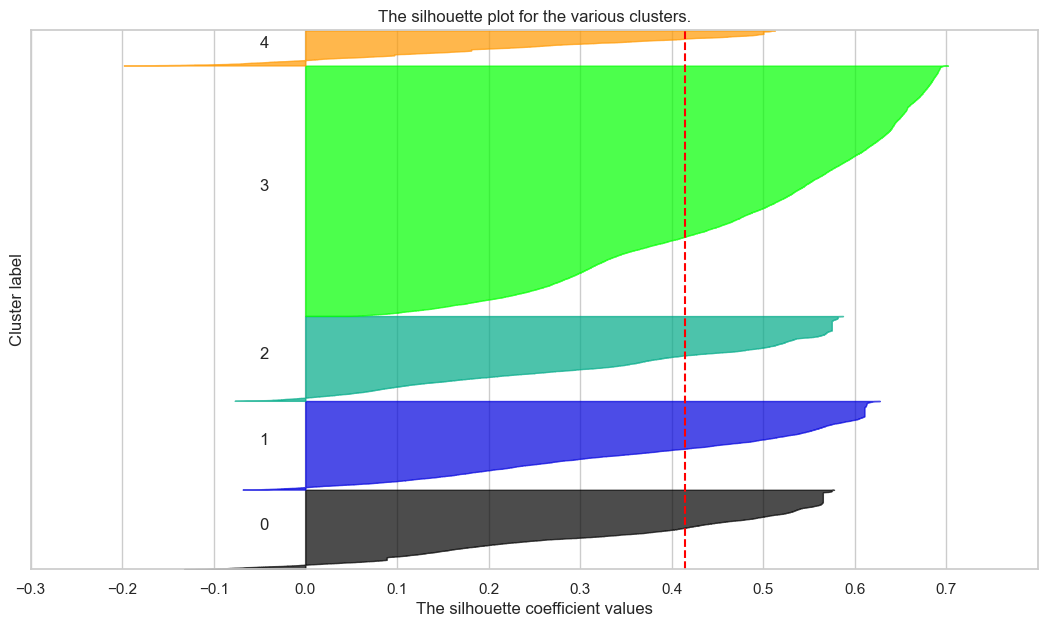

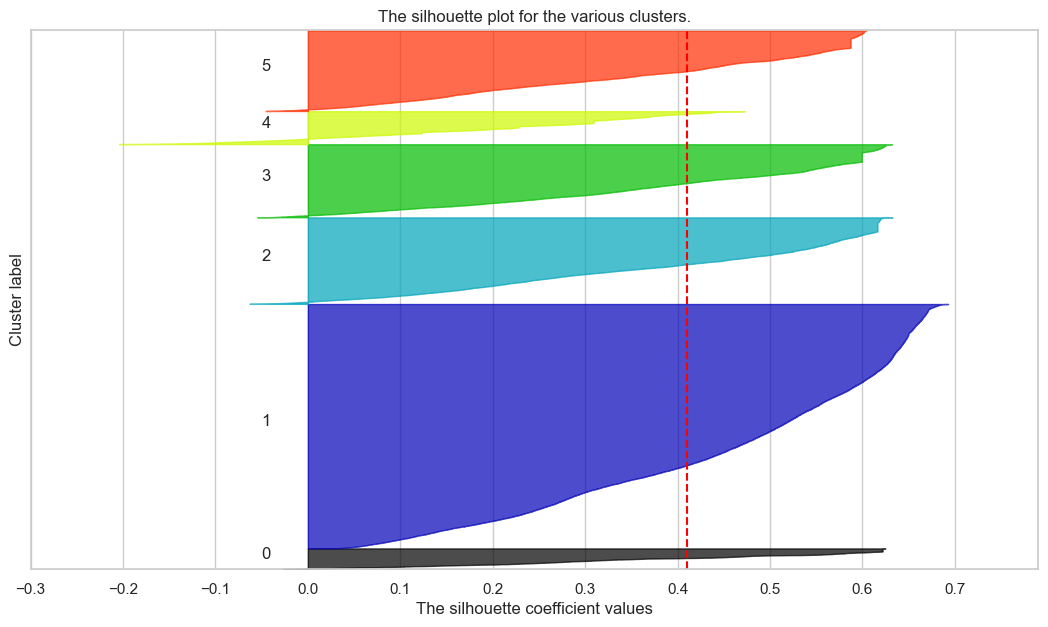

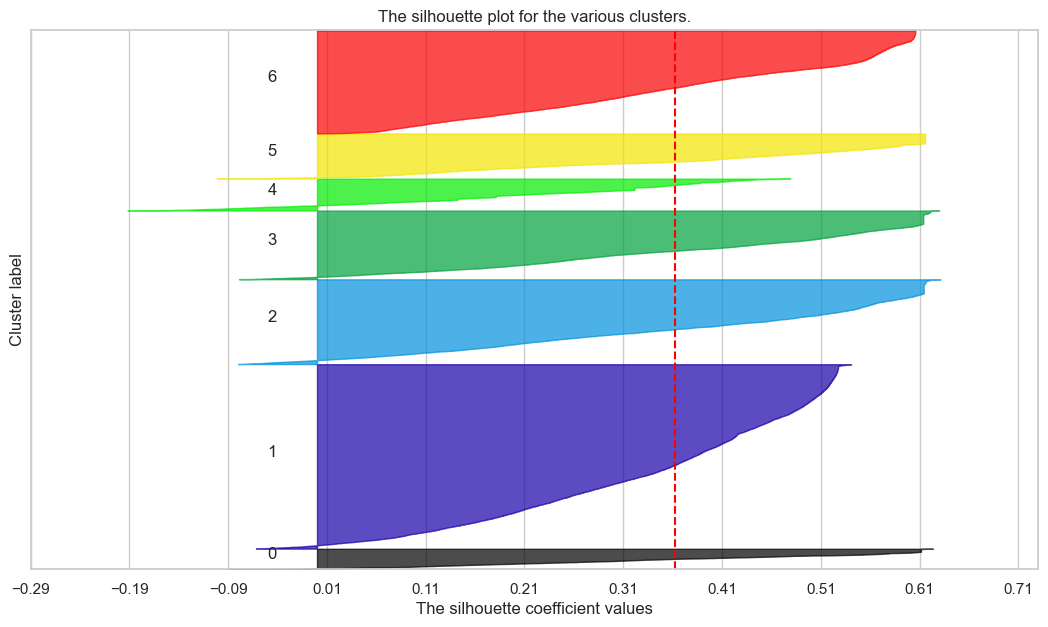

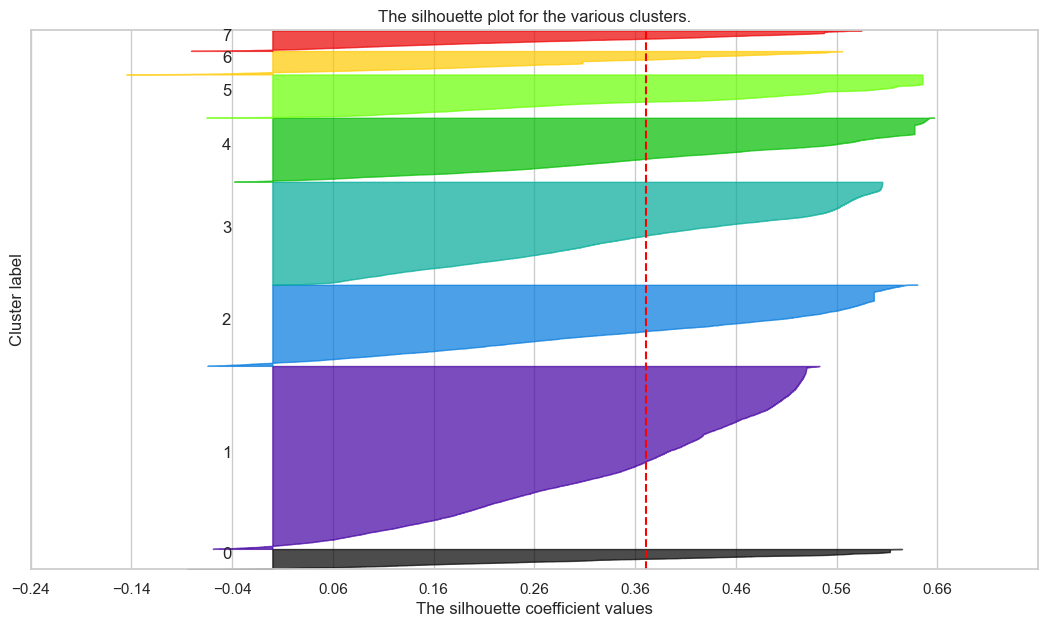

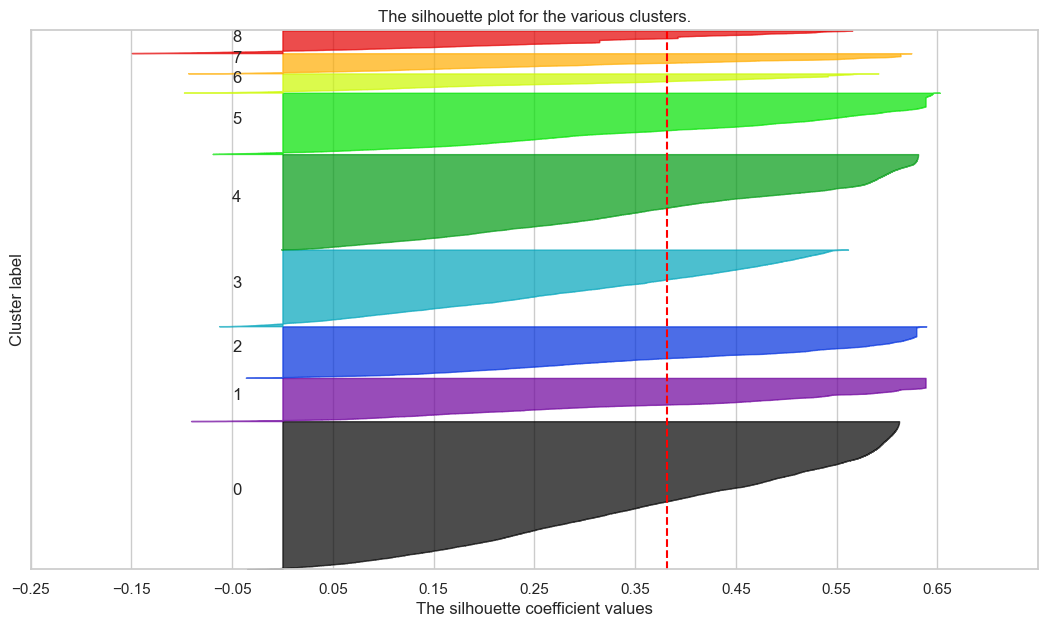

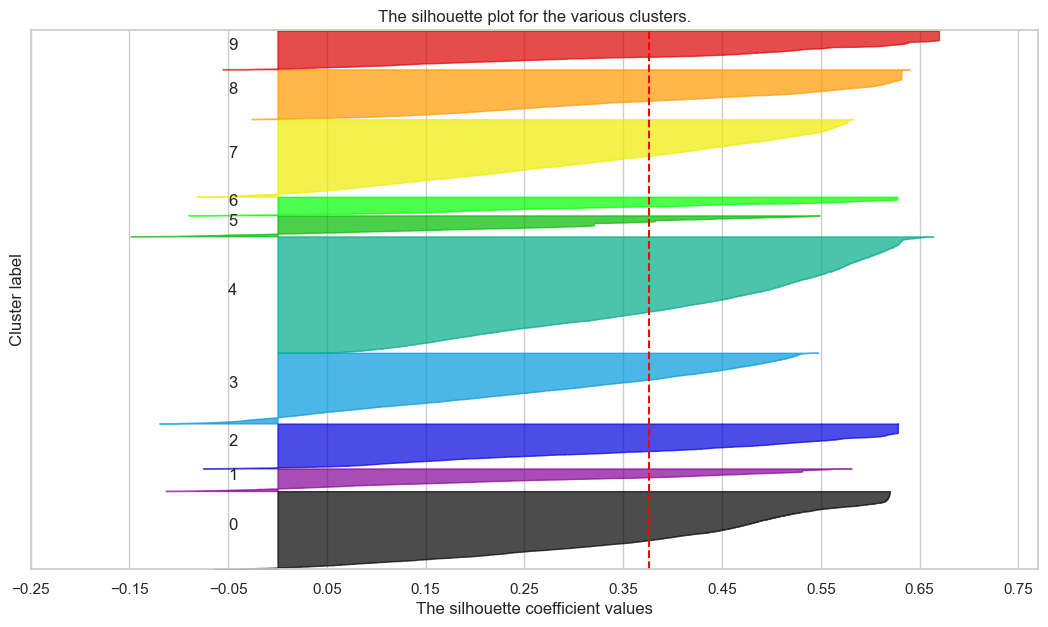

In [10]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=50, random_state=202)
    cluster_labels = kmclust.fit_predict(df_pref)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_pref, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pref, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    sns.set_style("whitegrid")
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_pref) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

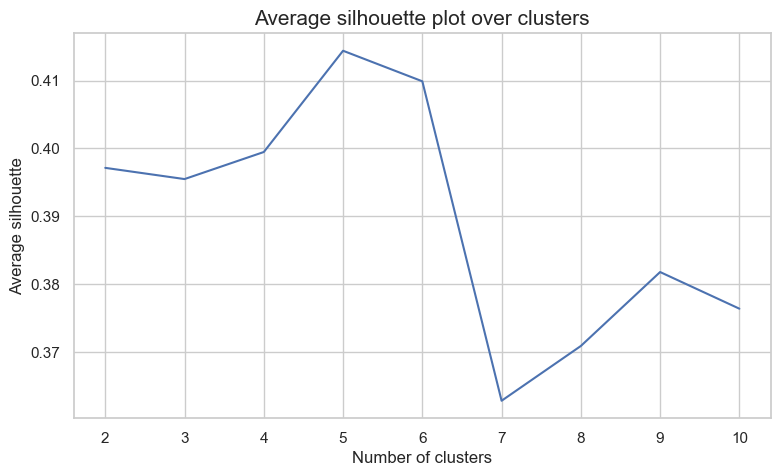

In [11]:
# The average silhouette plot
# The inertia plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [12]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km3_labels1 = kmclust.fit_predict(df_beh)
km3_labels1

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [13]:
type(df.columns)

pandas.core.indexes.base.Index

In [14]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km3_labels1, name='beh_labels3', index=df.index)), axis=1)
cluster_means = df_concat.groupby('beh_labels3').mean()[behavior_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1, cmap='viridis')


beh_labels3,0,1,2
Total_Orders,0.32,0.08,0.88
Spent_Per_Order,0.34,0.47,0.31
Time_with_us,0.55,0.07,0.78


In [15]:
# check how many observations in each cluster
df_concat['beh_labels3'].value_counts()

beh_labels3
1    13604
0    11521
2     6612
Name: count, dtype: int64

In [16]:
label_column = df_concat['beh_labels3']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_beh, label_column)

# Display or return R² results
print(r2_result)

Total_Orders       0.842597
Spent_Per_Order    0.073188
Time_with_us       0.791956
dtype: float64


In [17]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km4_labels1 = kmclust.fit_predict(df_beh)
km4_labels1

array([0, 3, 3, ..., 0, 3, 3], dtype=int32)

In [18]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km4_labels1, name='beh_labels4', index=df.index)), axis=1)
cluster_means = df_concat.groupby('beh_labels4').mean()[behavior_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

beh_labels4,0,1,2,3
Total_Orders,0.09,0.34,0.90,0.11
Spent_Per_Order,0.82,0.33,0.31,0.28
Time_with_us,0.11,0.60,0.78,0.11


In [19]:
# check how many observations in each cluster
df_concat['beh_labels4'].value_counts()

beh_labels4
3    10412
1     9829
2     6357
0     5139
Name: count, dtype: int64

In [20]:
label_column = df_concat['beh_labels4']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_beh, label_column)

# Display or return R² results
print(r2_result)

Total_Orders       0.835465
Spent_Per_Order    0.553039
Time_with_us       0.780357
dtype: float64


In [21]:
number_clusters = 5
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km5_labels1 = kmclust.fit_predict(df_beh)
km5_labels1

array([3, 0, 0, ..., 3, 0, 0], dtype=int32)

In [22]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km5_labels1, name='beh_labels5', index=df.index)), axis=1)
cluster_means = df_concat.groupby('beh_labels5').mean()[behavior_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

beh_labels5,0,1,2,3,4
Total_Orders,0.11,0.34,0.34,0.05,0.91
Spent_Per_Order,0.28,0.67,0.24,0.82,0.30
Time_with_us,0.10,0.58,0.58,0.05,0.79


In [23]:
# check how many observations in each cluster
df_concat['beh_labels5'].value_counts()

beh_labels5
0    10106
2     7857
4     6054
3     4326
1     3394
Name: count, dtype: int64

In [24]:
label_column = df_concat['beh_labels5']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_beh, label_column)

# Display or return R² results
print(r2_result)

Total_Orders       0.837753
Spent_Per_Order    0.678571
Time_with_us       0.804173
dtype: float64


<hr>
<a class="anchor" id="kmtime">
    
## 3.2 Time Features

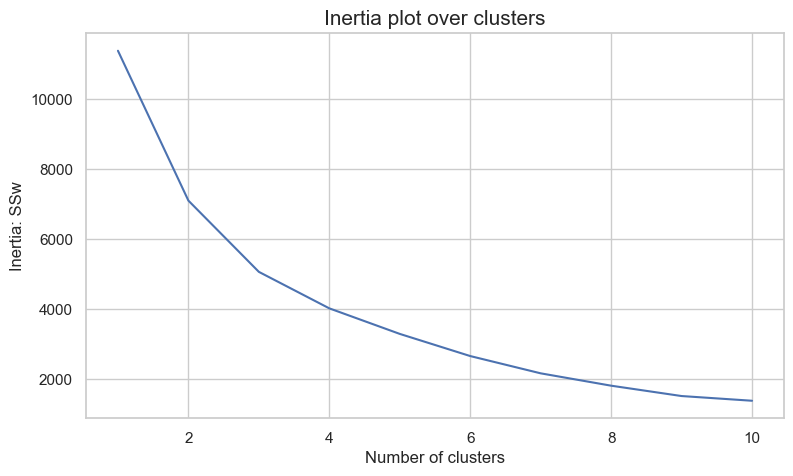

In [25]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=50, random_state=202)
    kmclust.fit(df_time)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.41263767854635647
For n_clusters = 3, the average silhouette_score is : 0.429264602738332
For n_clusters = 4, the average silhouette_score is : 0.42154530239824584
For n_clusters = 5, the average silhouette_score is : 0.4239904170649488
For n_clusters = 6, the average silhouette_score is : 0.4391318051504303
For n_clusters = 7, the average silhouette_score is : 0.4708820604377245
For n_clusters = 8, the average silhouette_score is : 0.47583731075293506
For n_clusters = 9, the average silhouette_score is : 0.48171643193912933
For n_clusters = 10, the average silhouette_score is : 0.4923009553284997


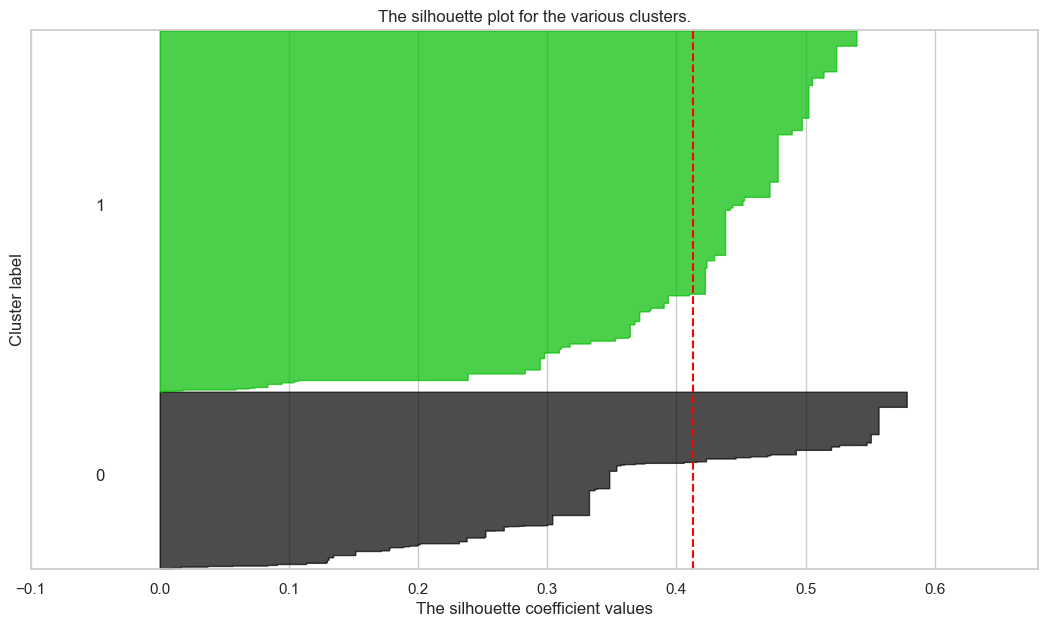

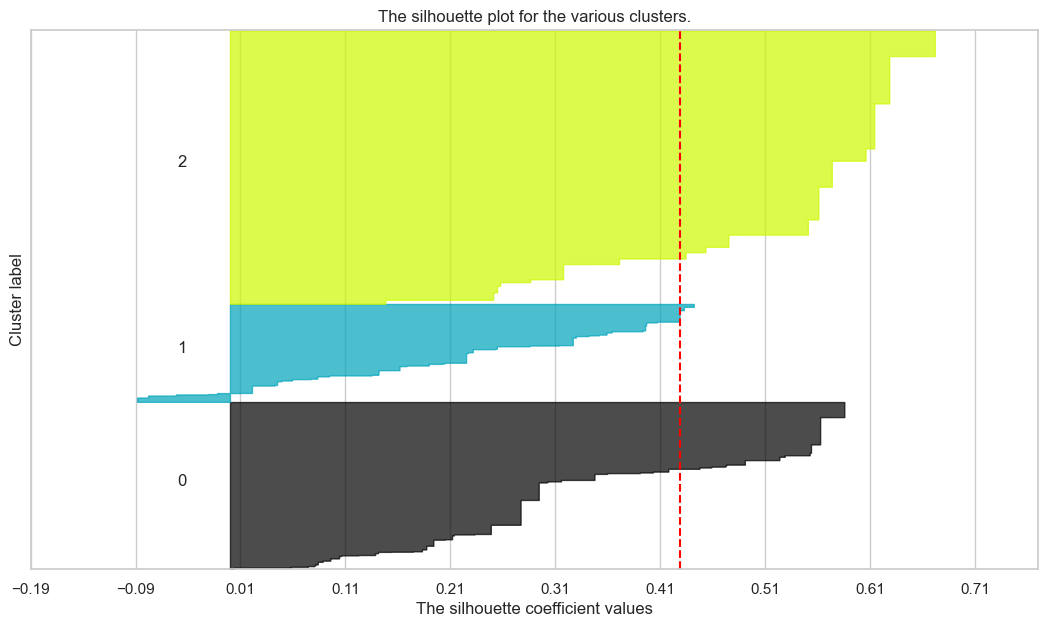

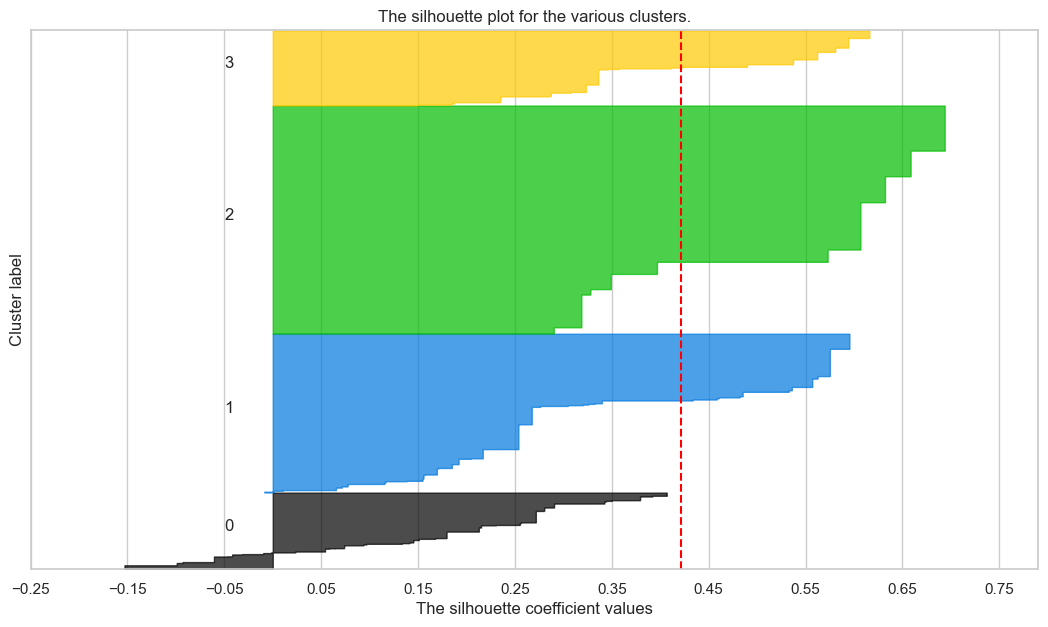

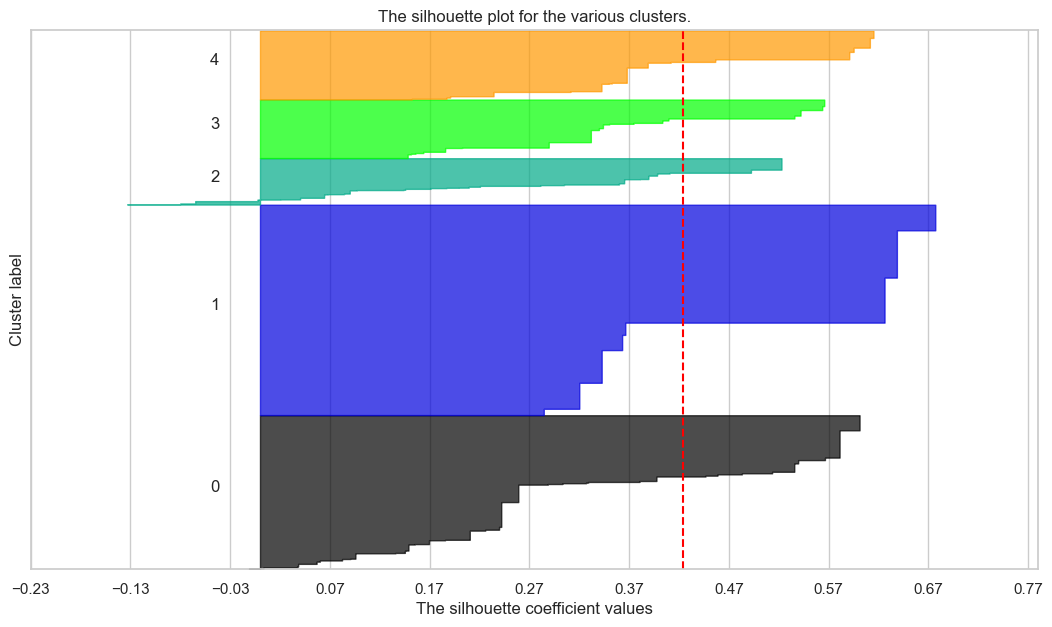

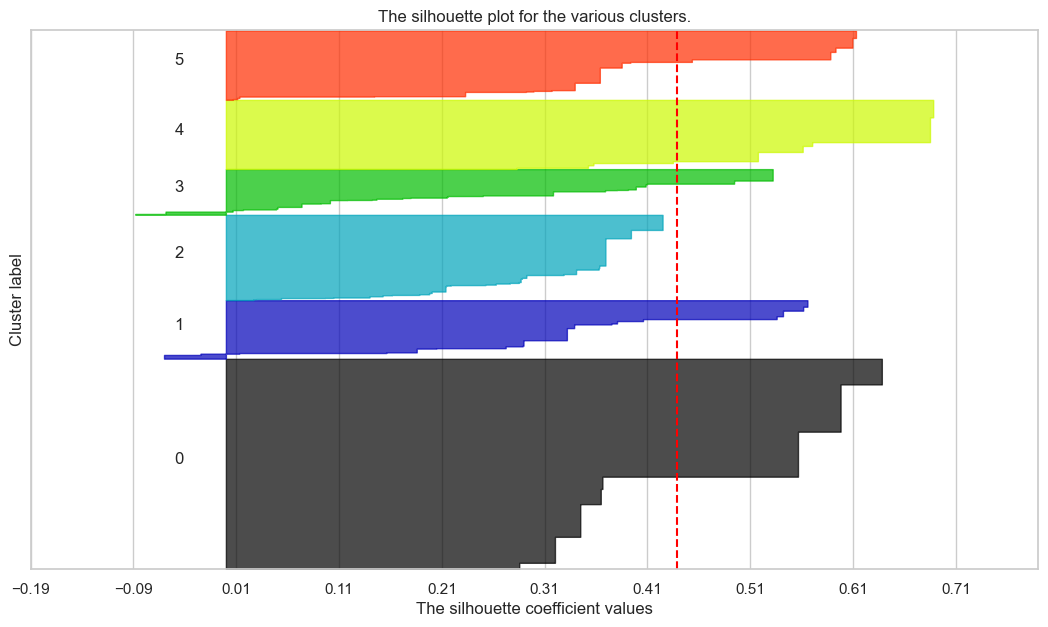

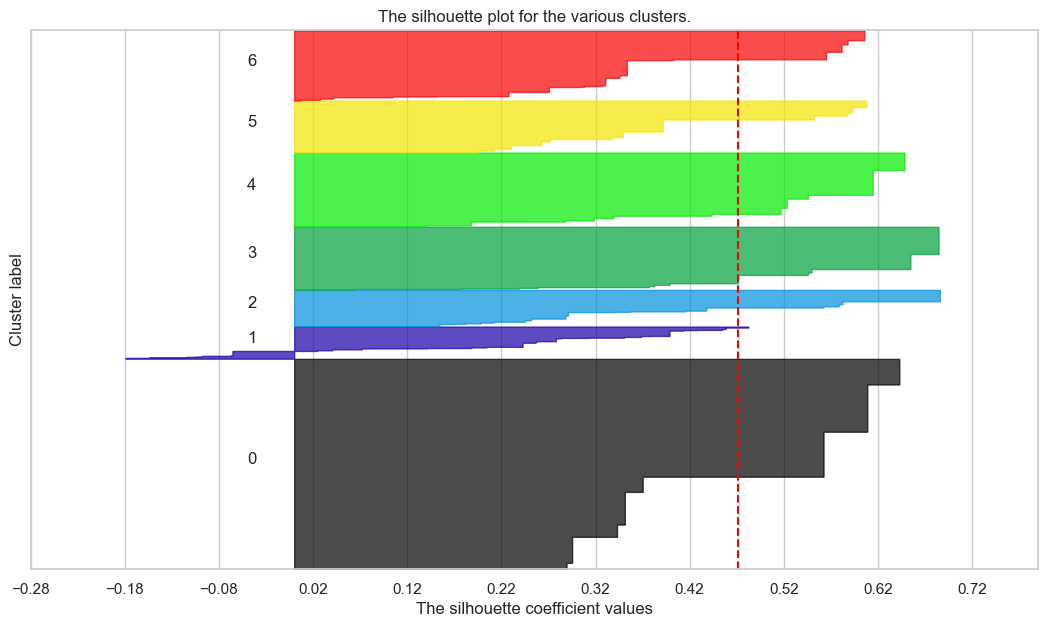

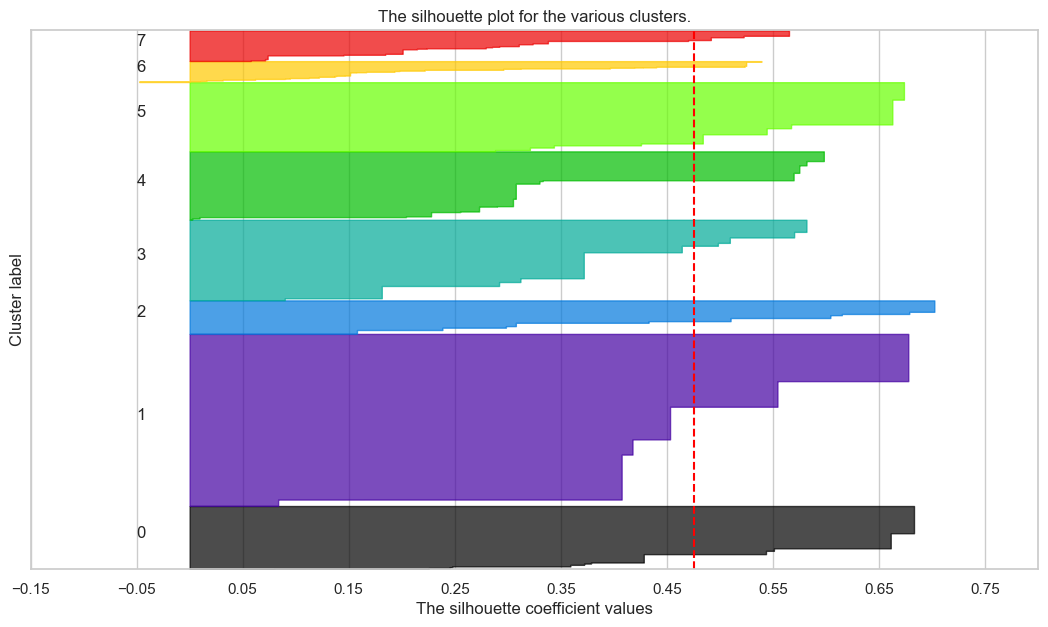

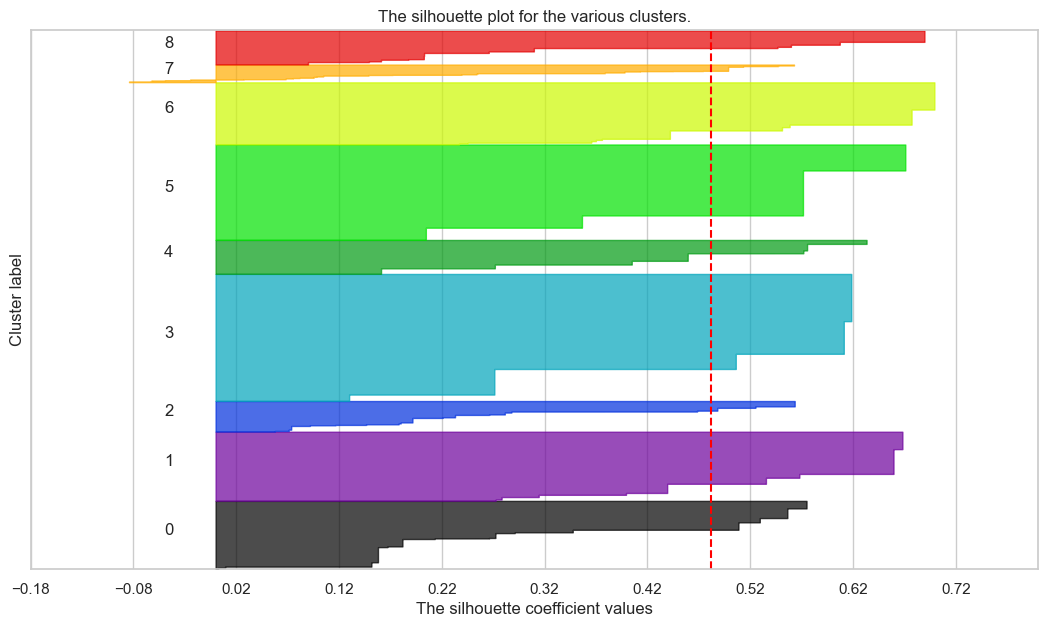

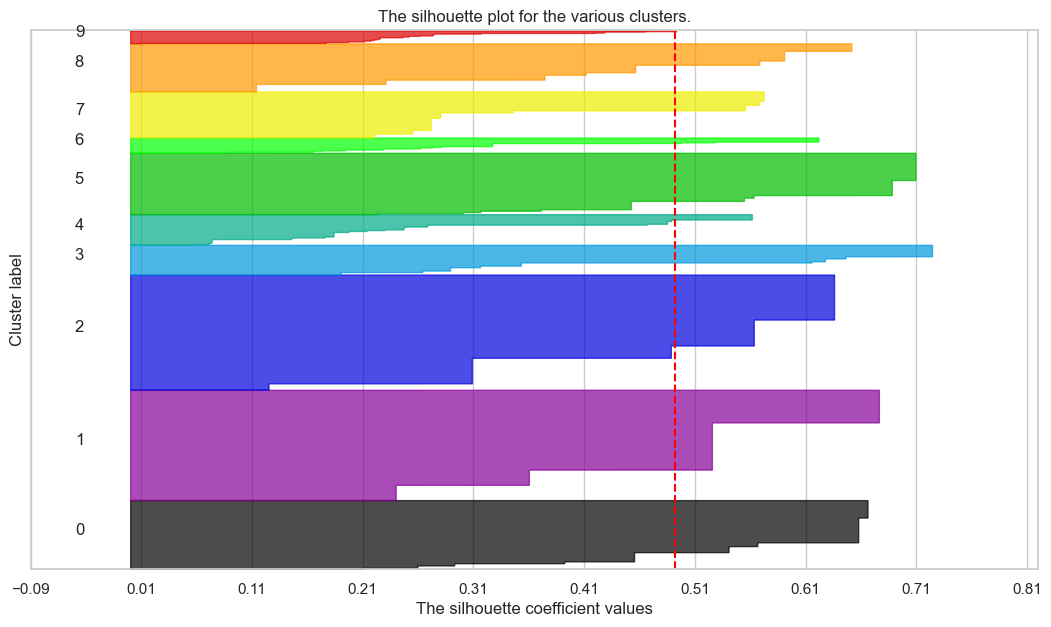

In [26]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_time)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_time, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_time, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    sns.set_style("whitegrid")
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_time) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

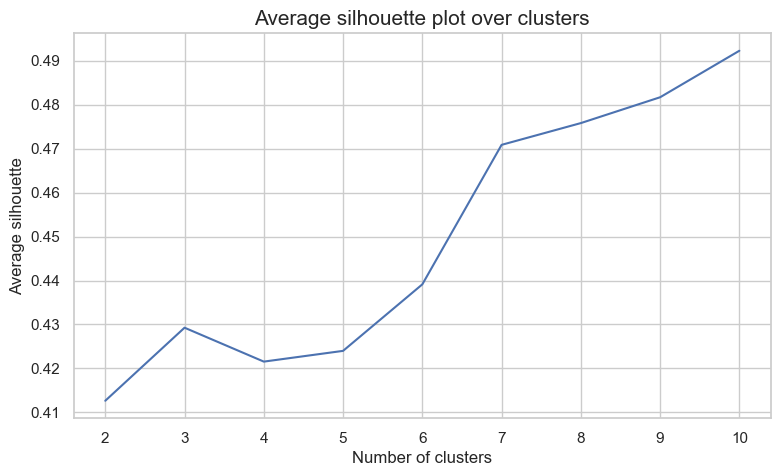

In [27]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

sns.set_style("whitegrid")
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [28]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km3_labels2 = kmclust.fit_predict(df_time)
km3_labels2

array([2, 2, 2, ..., 0, 2, 2], dtype=int32)

In [29]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km3_labels2, name='time_labels3', index=df.index)), axis=1)
cluster_means = df_concat.groupby('time_labels3').mean()[time_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

time_labels3,0,1,2
Night,0.75,0.15,0.00
Day,0.26,0.54,0.24
Dinner,0.09,0.85,0.21


In [30]:
# check how many observations in each cluster
df_concat['time_labels3'].value_counts()

time_labels3
2    16117
0     9849
1     5771
Name: count, dtype: int64

In [31]:
label_column = df_concat['time_labels3']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_time, label_column)

# Display or return R² results
print(r2_result)

Night     0.754718
Day       0.124329
Dinner    0.684807
dtype: float64


In [32]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km4_labels2 = kmclust.fit_predict(df_time)
km4_labels2

array([0, 3, 3, ..., 1, 3, 3], dtype=int32)

In [33]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km4_labels2, name='time_labels4', index=df.index)), axis=1)
cluster_means = df_concat.groupby('time_labels4').mean()[time_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

time_labels4,0,1,2,3
Night,0.03,0.76,0.20,0.00
Day,0.11,0.23,0.89,0.25
Dinner,0.63,0.09,0.62,0.11


In [34]:
# check how many observations in each cluster
df_concat['time_labels4'].value_counts()

time_labels4
3    10948
1     9482
0     6958
2     4349
Name: count, dtype: int64

In [35]:
label_column = df_concat['time_labels4']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_time, label_column)

# Display or return R² results
print(r2_result)

Night     0.747659
Day       0.561523
Dinner    0.586023
dtype: float64


In [36]:
number_clusters = 5
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km5_labels2 = kmclust.fit_predict(df_time)
km5_labels2

array([3, 3, 3, ..., 1, 3, 3], dtype=int32)

In [37]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km5_labels2, name='time_labels5', index=df.index)), axis=1)
cluster_means = df_concat.groupby('time_labels5').mean()[time_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

time_labels5,0,1,2,3,4
Night,0.04,0.77,0.07,0.00,0.35
Day,0.13,0.22,0.79,0.17,0.85
Dinner,0.78,0.08,0.19,0.18,0.93


In [38]:
# check how many observations in each cluster
df_concat['time_labels5'].value_counts()

time_labels5
3    12409
1     9176
0     4069
2     3650
4     2433
Name: count, dtype: int64

In [39]:
label_column = df_concat['time_labels5']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_time, label_column)

# Display or return R² results
print(r2_result)

Night     0.747758
Day       0.615410
Dinner    0.747917
dtype: float64


In [40]:
# Characterizing the final clusters
#df_concat = pd.concat((df, pd.Series(km_labels, name='labels', index=df.index)), axis=1)
#df_concat.groupby('labels').mean()

<hr>
<a class="anchor" id="kmpref">
    
## 3.3 Preference Features

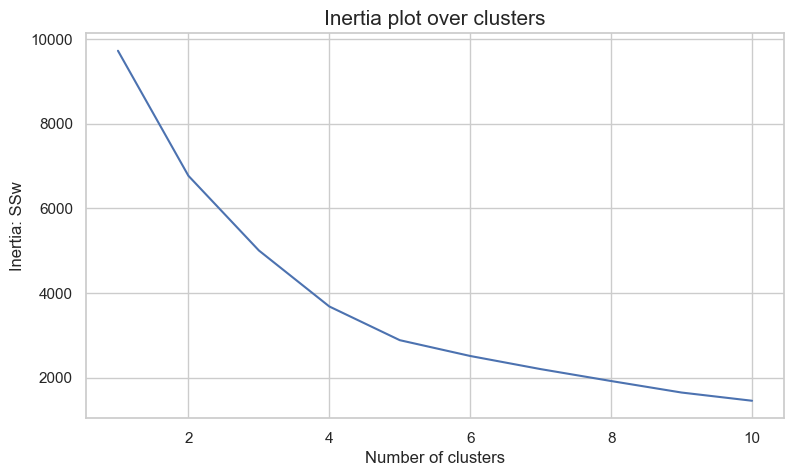

In [41]:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_pref)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

# The inertia plot
sns.set_style("whitegrid")
plt.figure(figsize=(9,5))
plt.plot(range_clusters, inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.3971497833282914
For n_clusters = 3, the average silhouette_score is : 0.3955003600165698
For n_clusters = 4, the average silhouette_score is : 0.399481681767867
For n_clusters = 5, the average silhouette_score is : 0.41438004679027124
For n_clusters = 6, the average silhouette_score is : 0.40988572498804327
For n_clusters = 7, the average silhouette_score is : 0.36288495353766803
For n_clusters = 8, the average silhouette_score is : 0.3709446478401913
For n_clusters = 9, the average silhouette_score is : 0.38182236051158325
For n_clusters = 10, the average silhouette_score is : 0.3764295766935262


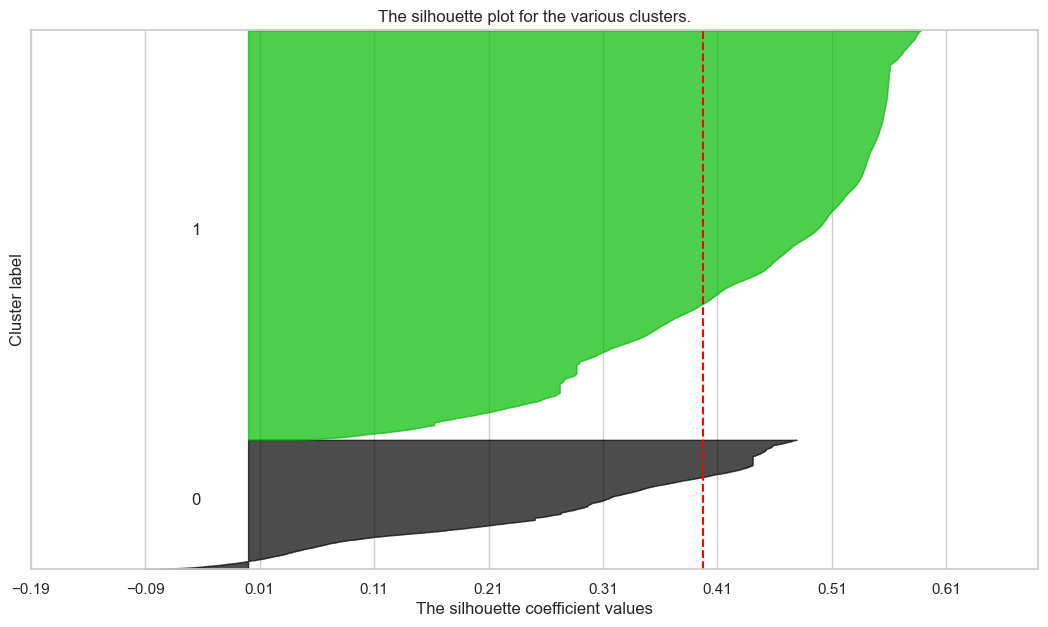

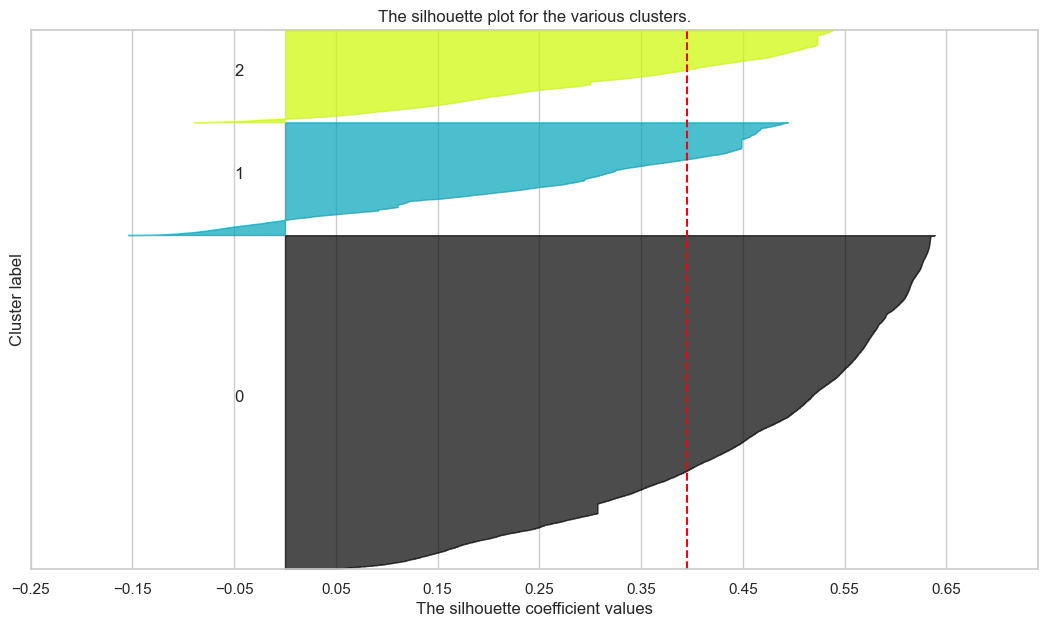

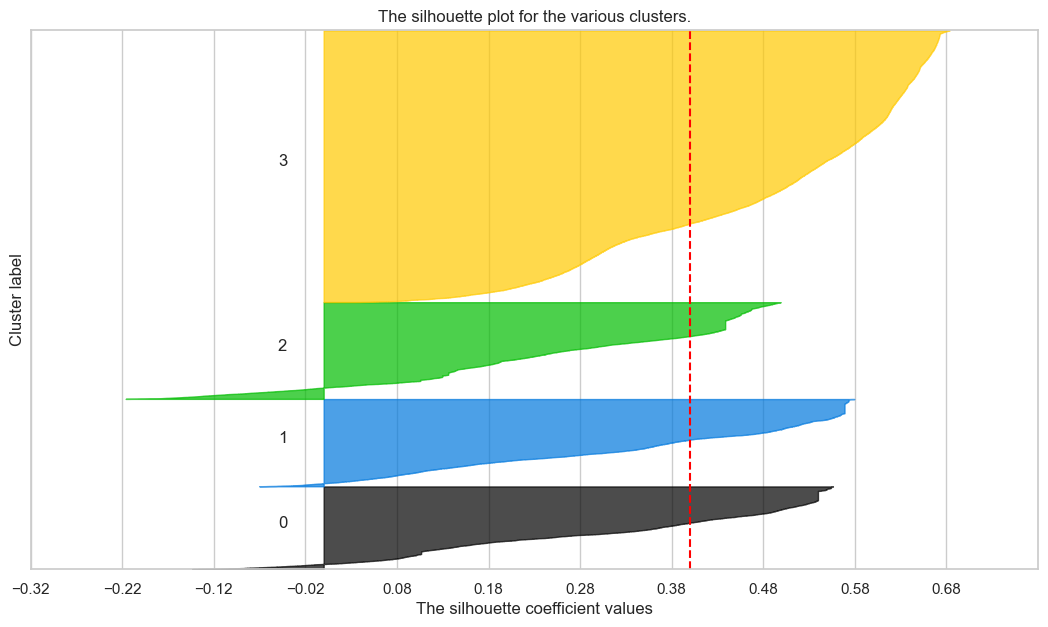

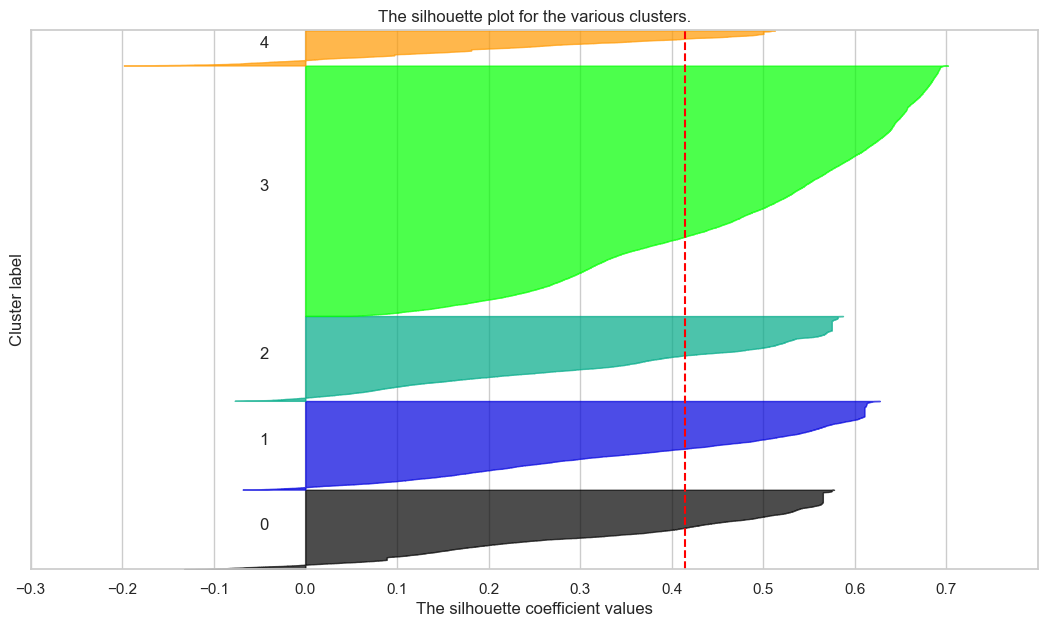

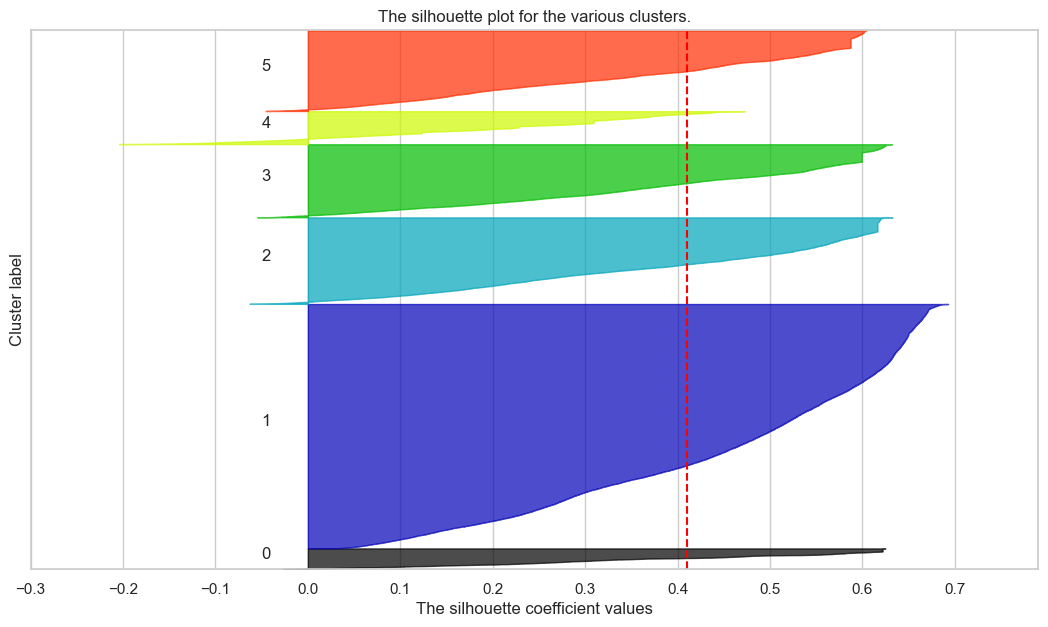

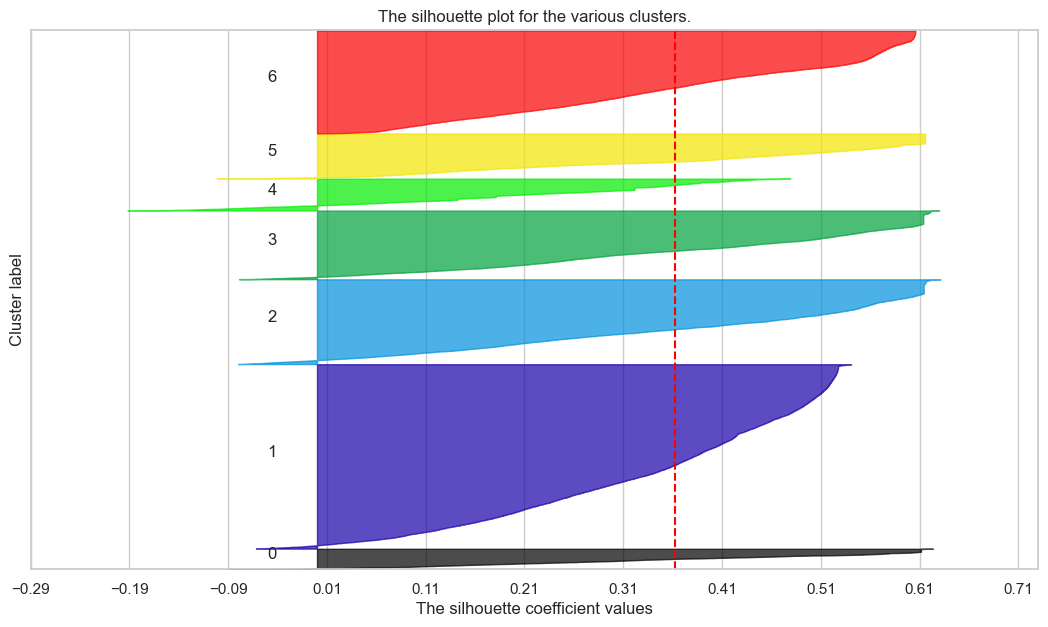

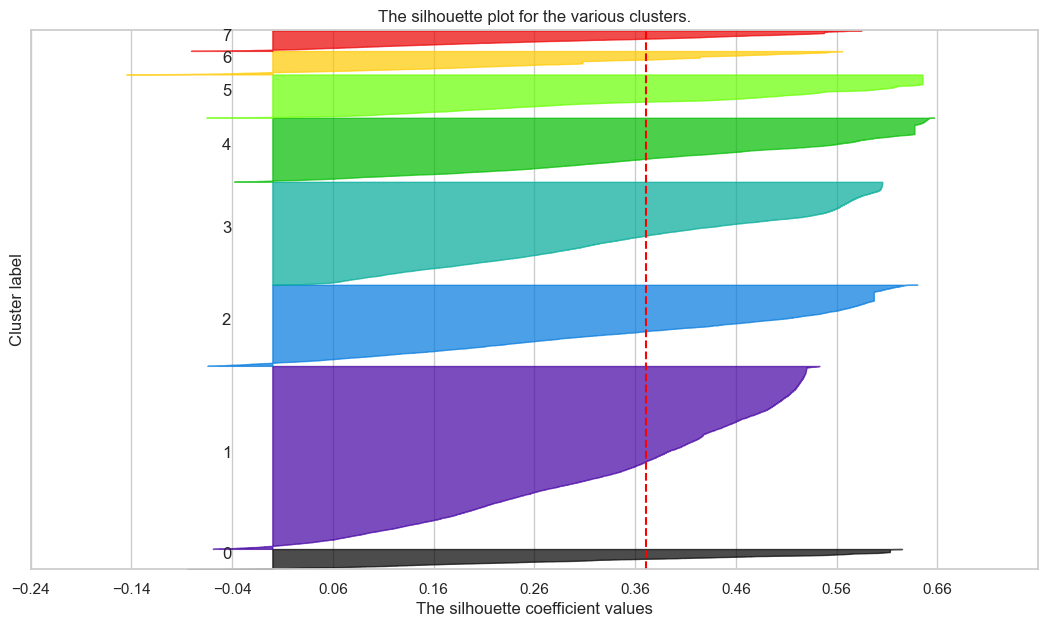

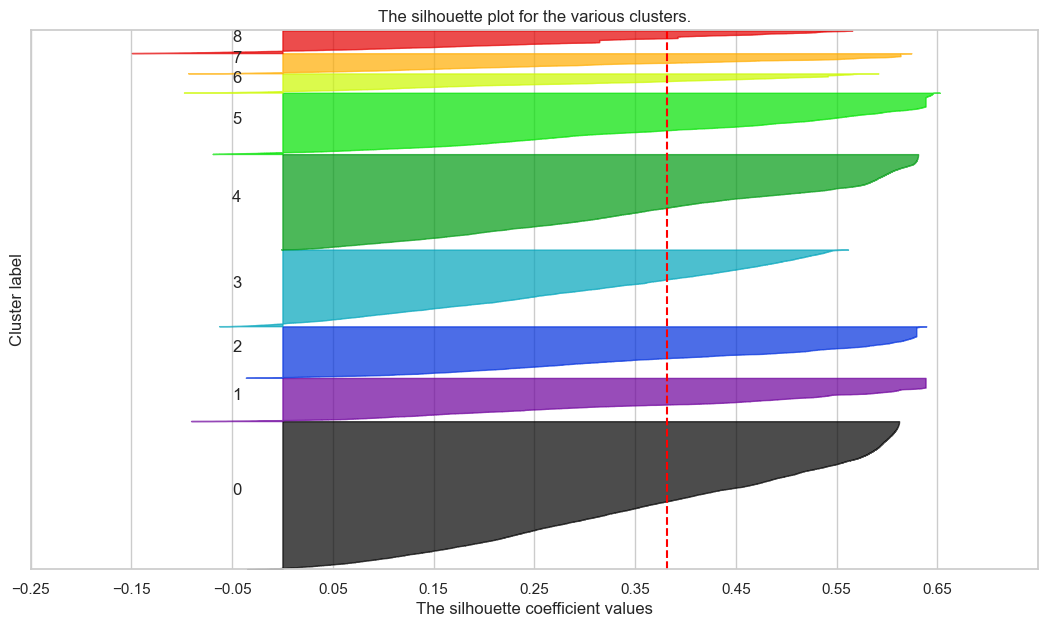

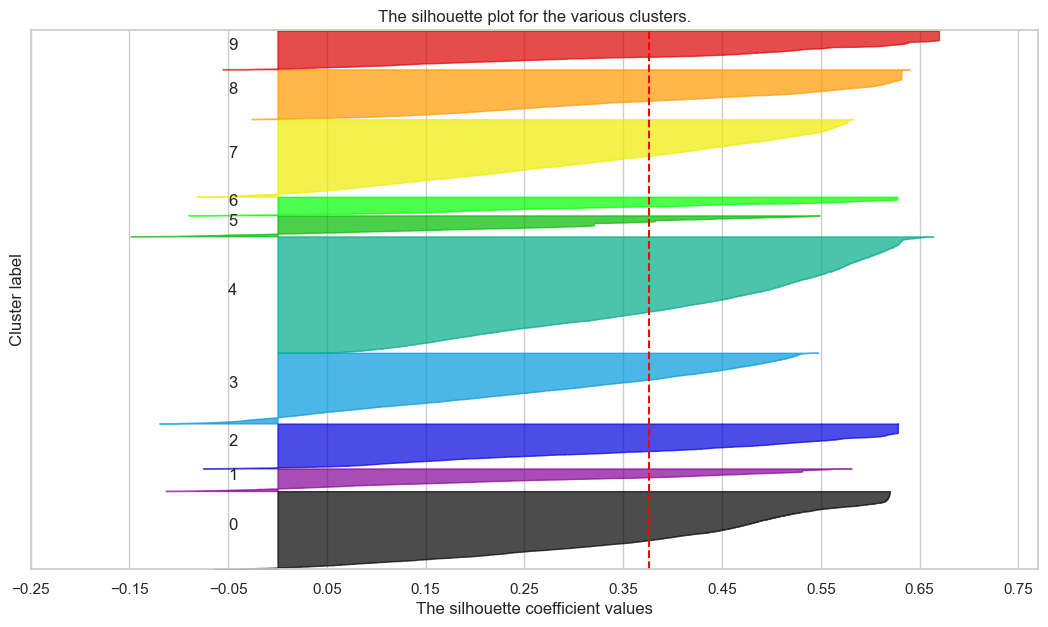

In [42]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=50, random_state=202)
    cluster_labels = kmclust.fit_predict(df_pref)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_pref, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pref, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    sns.set_style("whitegrid")
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_pref) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

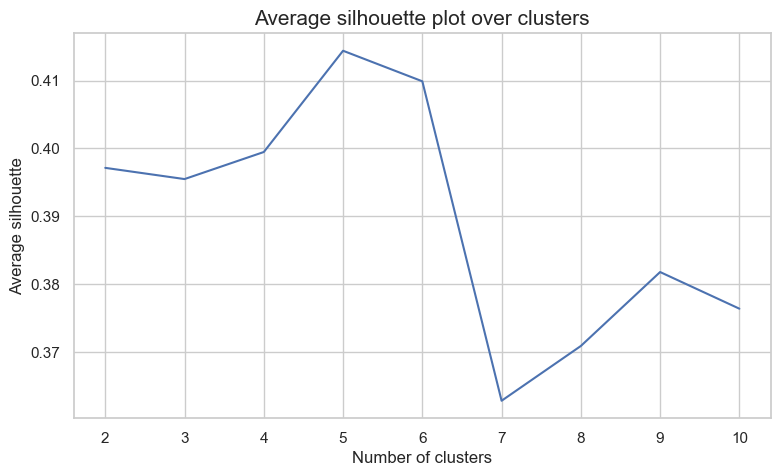

In [43]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], ## Plot X-axis; Why range_clusters[1:] ? Remember we skipped k=1 in the cell above
         avg_silhouette)     ## Plot Y-axis

sns.set_style("whitegrid")
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [44]:
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km3_labels3 = kmclust.fit_predict(df_pref)
km3_labels3

array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

In [45]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km3_labels3, name='pref_labels3', index=df.index)), axis=1)
cluster_means = df_concat.groupby('pref_labels3').mean()[preferences_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

pref_labels3,0,1,2
Asian,0.24,0.30,0.25
Western,0.11,0.24,0.77
Other,0.08,0.81,0.09


In [46]:
# check how many observations in each cluster
df_concat['pref_labels3'].value_counts()

pref_labels3
0    19672
1     6633
2     5432
Name: count, dtype: int64

In [47]:
label_column = df_concat['pref_labels3']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_pref, label_column)

# Display or return R² results
print(r2_result)

Asian      0.006353
Western    0.611004
Other      0.785969
dtype: float64


In [48]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=50, random_state=202)
km4_labels3 = kmclust.fit_predict(df_pref)
km4_labels3

array([1, 3, 3, ..., 2, 3, 3], dtype=int32)

In [49]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km4_labels3, name='pref_labels4', index=df.index)), axis=1)
cluster_means = df_concat.groupby('pref_labels4').mean()[preferences_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

pref_labels4,0,1,2,3
Asian,0.21,0.72,0.29,0.11
Western,0.80,0.12,0.26,0.12
Other,0.09,0.08,0.86,0.10


In [50]:
# check how many observations in each cluster
df_concat['pref_labels4'].value_counts()

pref_labels4
3    16017
2     5702
1     5144
0     4874
Name: count, dtype: int64

In [51]:
label_column = df_concat['pref_labels4']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_pref, label_column)

# Display or return R² results
print(r2_result)

Asian      0.484370
Western    0.587060
Other      0.767377
dtype: float64


In [52]:
number_clusters = 5
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km5_labels3 = kmclust.fit_predict(df_pref)
km5_labels3

array([3, 0, 0, ..., 1, 0, 0], dtype=int32)

In [53]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km5_labels3, name='pref_labels5', index=df.index)), axis=1)
cluster_means = df_concat.groupby('pref_labels5').mean()[preferences_features].T
cluster_means.style.format(precision=2).background_gradient(axis=1)

pref_labels5,0,1,2,3,4
Asian,0.11,0.11,0.18,0.72,0.70
Western,0.13,0.10,0.79,0.11,0.63
Other,0.07,0.75,0.07,0.06,0.86


In [54]:
# check how many observations in each cluster
df_concat['pref_labels5'].value_counts()

pref_labels5
0    14766
1     5221
3     5006
2     4679
4     2065
Name: count, dtype: int64

In [55]:
label_column = df_concat['pref_labels5']  # Adjust this to your label column name

# Compute R² for each variable and drop the label column
r2_result = r2_variables(df_pref, label_column)

# Display or return R² results
print(r2_result)

Asian      0.623321
Western    0.675512
Other      0.795067
dtype: float64


## Merging the Perspectives

In [56]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_beh = KMeans(
    n_clusters=5,
    init='k-means++',
    n_init=50,
    random_state=202
)
beh_labels = kmeans_beh.fit_predict(df_beh)

kmeans_time = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=50,
    random_state=202
)
time_labels = kmeans_time.fit_predict(df_time)

kmeans_pref = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=50,
    random_state=202
)
pref_labels = kmeans_pref.fit_predict(df_pref)

df['beh_labels'] = beh_labels
df['time_labels'] = time_labels
df['pref_labels'] = pref_labels

In [57]:
# display number of observations in each cluster of each perspective
df['beh_labels'].value_counts(), df['time_labels'].value_counts(), df['pref_labels'].value_counts()

(beh_labels
 4    10115
 0     7854
 2     6054
 1     4335
 3     3379
 Name: count, dtype: int64,
 time_labels
 3    10948
 1     9482
 0     6958
 2     4349
 Name: count, dtype: int64,
 pref_labels
 3    16017
 2     5702
 1     5144
 0     4874
 Name: count, dtype: int64)

In [58]:
# Centroids of the cluster labels
#df_centroids = df.groupby(['beh_labels', 'time_labels', 'pref_labels'])\
    #[metric_features].mean()
#df_centroids

## Cluster visualization using t-SNE

In [59]:
from sklearn.manifold import TSNE
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df)

In [71]:
df['merged_labels']=df['beh_labels'].astype(str) + df['time_labels'].astype(str) + df['pref_labels'].astype(str)
df['merged_labels']

0        101
1        433
2        433
3        131
4        131
        ... 
31732    132
31733    133
31734    112
31735    433
31736    433
Name: merged_labels, Length: 31737, dtype: object

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0        101
1        433
2        433
3        131
4        131
        ... 
31732    132
31733    133
31734    112
31735    433
31736    433
Name: merged_labels, Length: 31737, dtype: object

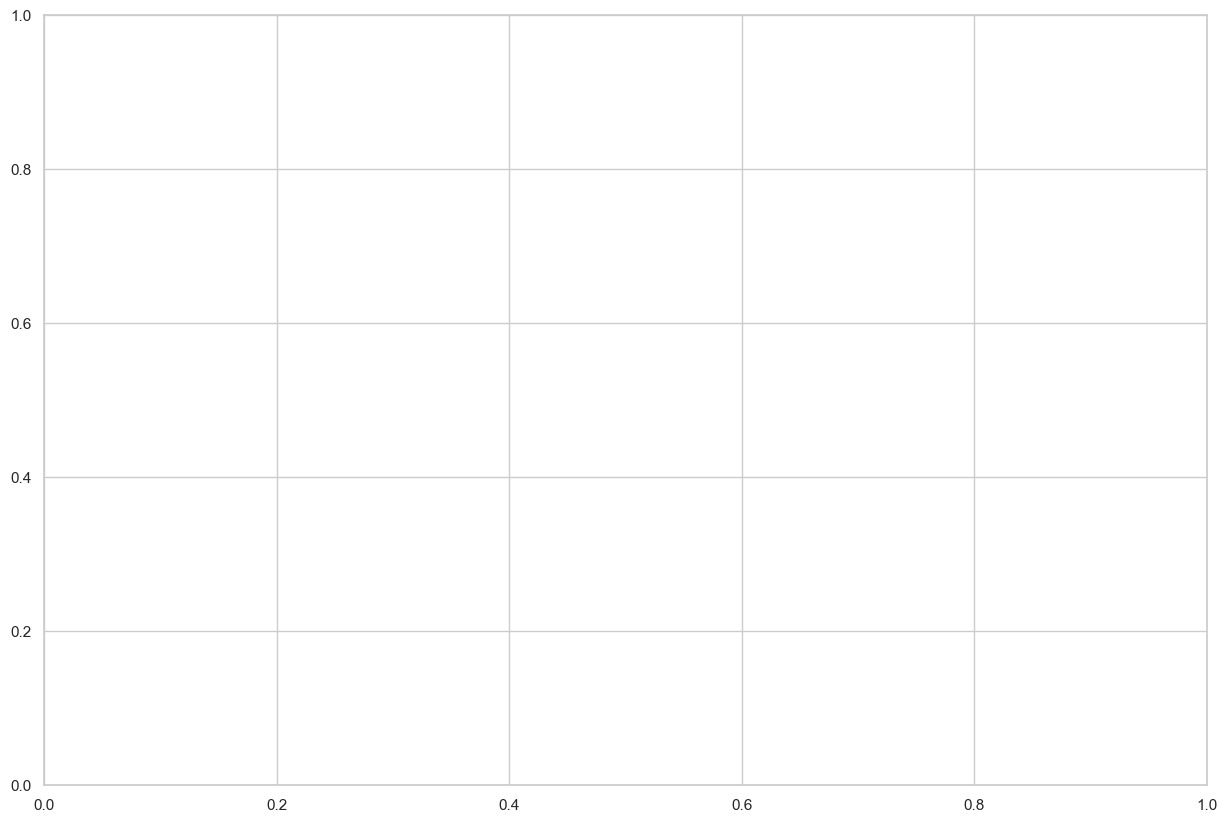

In [61]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

In [ ]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [ ]:
# Profilling each cluster (product, time, merged)
cluster_profiles(
    df = df.to_list() + ['beh_labels', 'time_labels', 'pref_labels' 'merged_labels'], 
    label_columns = ['beh_labels', 'time_labels', 'pref_labels','merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Behavior Clustering", "Time Clustering", 'Preference Clustering' "Merged clusters"]
)